In [43]:
from pysilero_vad import SileroVoiceActivityDetector
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import wave
import librosa as lr
from pathlib import Path
import noisereduce as nr

In [44]:
def int2float(sound):
    abs_max = np.abs(sound).max()
    sound = sound.astype("float32")
    if abs_max > 0:
        sound *= 1 / 32768
    sound = sound.squeeze()  # depends on the use case
    return sound

def pad_with_zeros(array, target_length):
    """
    Pads a NumPy array with zeros if its length is less than the target length.

    Parameters:
    array (numpy.ndarray): Input array to be padded.
    target_length (int): Desired length of the array after padding.

    Returns:
    numpy.ndarray: Padded array with the specified target length.
    """
    current_length = len(array)
    
    if current_length < target_length:
        # Calculate the number of zeros to append
        padding_length = target_length - current_length
        # Create a zero array of the required length
        padding = np.zeros(padding_length, dtype=array.dtype)
        # Append the zero array to the original array
        array = np.concatenate((array, padding))
    
    return array

In [73]:
file_name = "mems_16k_give_me_apple_200cm"
wav_file = Path.joinpath(Path.cwd(), "wavs-16k", f"{file_name}.wav")

sample_rate = 16000 Hz
80000


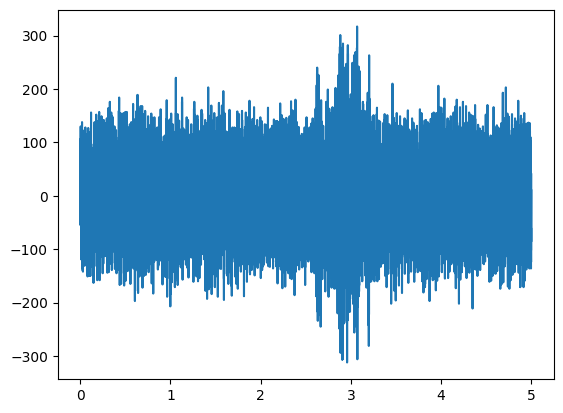

In [74]:
with sf.SoundFile(wav_file) as file:
    sample_rate = file.samplerate
    audio_data = file.read(dtype="int16")

t_samples = np.array([i / sample_rate for i in range(len(audio_data))])
print(f"{sample_rate = } Hz")
print(len(audio_data))

plt.plot(t_samples, audio_data)
plt.show()

In [47]:
# with wave.open(wav_file) as file:
#     sample_rate = file.getframerate()
#     nframes = file.getnframes()
#     audio_data = file.readframes(nframes)

# t_samples = np.array([i / sample_rate for i in range(nframes)])
# audio_data = np.frombuffer(audio_data, dtype=np.int16)
# print(f"{sample_rate = } Hz")
# plt.plot(t_samples, audio_data, ".-")
# plt.show()

In [48]:
# resample
# TARGET_SR = 16e3
# audio_data_float32 = audio_data.astype(np.float32) # need librosa resample needs float
# audio_resampled_float32 = lr.resample(audio_data_float32, orig_sr=sample_rate, target_sr=TARGET_SR)
# t_resampled = np.array([i / TARGET_SR for i in range(len(audio_resampled_float32))])
# plt.plot(t_samples, audio_data_float32, "r.-", t_resampled, audio_resampled_float32, "go-")
# plt.xlim(3.9, 3.91)

In [49]:
# audio_resampled_int16 = audio_resampled_float32.astype(np.int16)
# vad = SileroVoiceActivityDetector()
# plt.figure(figsize=(10,10))
# plt.plot(t_samples, audio_data, "r.-", t_resampled, audio_resampled_int16, "go-")
# plt.xlim(3.87, 3.9)
# plt.show()
# print(vad(audio_data))

In [50]:
# MIN_CHUNK_DURATION = 0.05
# SAMPLE_RATE = 16000
# CHUNK_SIZE = int(SAMPLE_RATE * MIN_CHUNK_DURATION)

# confidences = []
# for i in range(0, len(audio_resampled_int16), CHUNK_SIZE):
#     chunk = audio_resampled_int16[i:i+CHUNK_SIZE]
#     chunk = pad_with_zeros(chunk, CHUNK_SIZE)
#     new_confidence = vad(chunk)
#     confidences.append(new_confidence)

# confidence_times = np.array([i * CHUNK_SIZE / SAMPLE_RATE for i in range(len(confidences))])
# fig, axs = plt.subplots(2, 1, figsize=(10,10))
# axs[0].plot(t_resampled, audio_resampled_int16)
# axs[1].plot(confidence_times, confidences)
# plt.show()

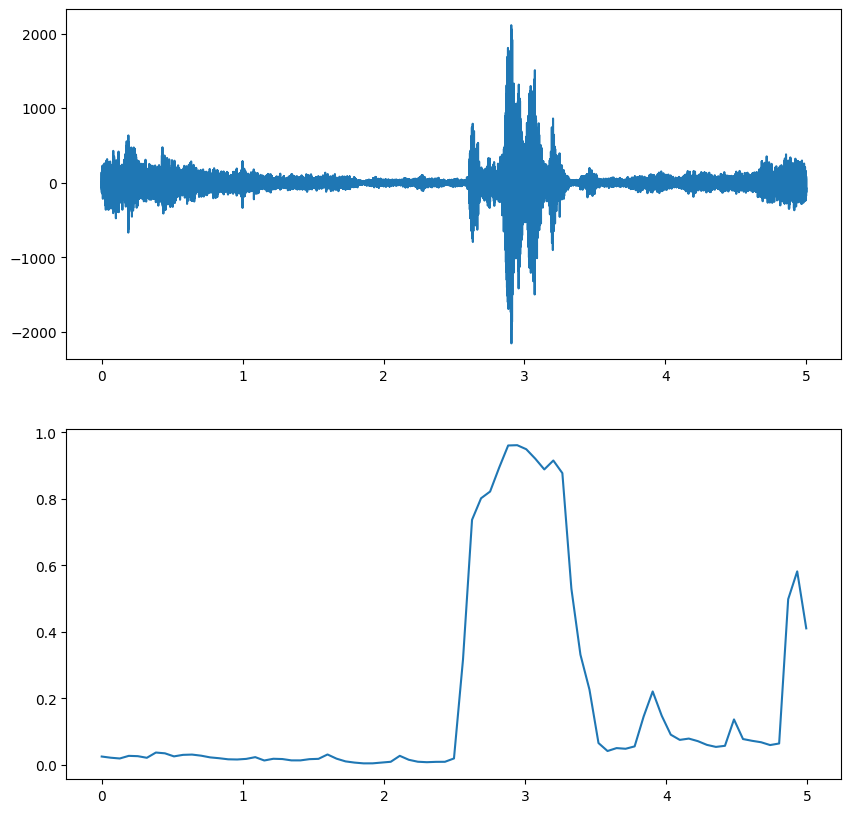

In [95]:
CHUNK_SIZE = 1024
GAIN = 20
MAX_LEVEL = 30000

# audio_nr = nr.reduce_noise(y=audio_data, sr=sample_rate)

# max_audio = np.abs(audio_nr).max()
# print(f"{max_audio = }")
# gain_diff = int(MAX_LEVEL / max_audio)
# print(gain_diff)
# audio_gain = audio_nr * gain_diff

audio_gain = audio_data * GAIN
audio_processed = nr.reduce_noise(y=audio_gain, sr=sample_rate)
# audio_processed = audio_gain

vad = SileroVoiceActivityDetector()

chunks = []
confidences = []
for i in range(0, len(audio_processed), CHUNK_SIZE):
    chunk = audio_processed[i:i+CHUNK_SIZE]
    chunk = pad_with_zeros(chunk, CHUNK_SIZE)
    # chunk = nr.reduce_noise(y=chunk, sr=sample_rate, stationary=False)
    new_confidence = vad(chunk)
    confidences.append(new_confidence)
    chunks.extend(chunk)

confidence_times = [i * CHUNK_SIZE / sample_rate for i in range(len(confidences))]
chunk_times = [i / sample_rate for i in range(len(chunks))]
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(t_samples, audio_processed)
# axs[0].plot(chunk_times, chunks)
axs[1].plot(confidence_times, confidences)
plt.show()

In [96]:
# Save audio to file
CHANNELS = 1
SAMPLE_RATE = 16000
with wave.open(f"{file_name}_nr.wav", "wb") as wf:
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(2)  # 2 bytes for int16
    wf.setframerate(SAMPLE_RATE)
    wf.writeframes(b"".join([audio_processed.tobytes()]))

In [53]:
# Save audio to file
# CHANNELS = 1
# SAMPLE_RATE = 16000
# with wave.open("resampled.wav", "wb") as wf:
#     wf.setnchannels(CHANNELS)
#     wf.setsampwidth(2)  # 2 bytes for int16
#     wf.setframerate(SAMPLE_RATE)
#     wf.writeframes(b"".join([audio_resampled_int16.tobytes()]))


In [54]:
2**(16-1)

32768

In [55]:
max_level = 2**(16-1) - 1
max_audio = np.abs(audio_nr).max()
print(f"{max_audio = }")
gain_diff = max_level / max_audio
norm_audio = audio_nr * gain_diff
norm_audio.max()

NameError: name 'audio_nr' is not defined

In [ ]:
print(len(audio_nr))
print(len(norm_audio))

In [ ]:
512/16e3

0.032

In [58]:
x = np.array([1,2,3], dtype=np.int16)
x

array([1, 2, 3], dtype=int16)

In [59]:
np.frombuffer(x, dtype=np.int16).astype(np.float32)

array([1., 2., 3.], dtype=float32)

In [61]:
def y(x, thresh):
    return x > thresh

y(1, 2)

False

In [66]:
import time

time.time()

1717445565.2636838